# MassSpringDamper - H2syn of LQG

## Mass Spring Damper System - Linear (1DOF)

$
A = \left[\begin{matrix}0 & 1\\- \frac{c_{1} + c_{2}}{m} & - \frac{d_{1} + d_{2}}{m}\end{matrix}\right]
$

$
B = \left[\begin{matrix}0\\\frac{1}{m}\end{matrix}\right]
$

$
C= \left[\begin{matrix}1 & 0\\0 & 1\end{matrix}\right]
$

$
D = \left[\begin{matrix}0\\0\end{matrix}\right]
$

**Generalized Plant**

$$
\begin{split}
\dot{\mathbf{x}} & = A \mathbf{x} + B_1 \mathbf{w} + B_2 \mathbf{u} \\
\mathbf{z} & = C_1 \mathbf{x} + D_{11} \mathbf{w} + D_{12} \mathbf{u} \\
\mathbf{y} & = C_2 \mathbf{x} + D_{21} \mathbf{w} + D_{22} \mathbf{u} \\
\end{split}
$$

**Generalized Plant LQG**

$$
\begin{split}
\dot{\mathbf{x}} & = A \mathbf{x} + \left[ \begin{matrix} \sqrt{Q_e} & 0 \end{matrix} \right]\mathbf{w} + B \mathbf{u} \\
\mathbf{z} & = \left[ \begin{matrix} \sqrt{Q} \\ 0 \end{matrix} \right] \mathbf{x} + \left[ \begin{matrix} 0 \\ \sqrt{R} \end{matrix} \right] \mathbf{u} \\
\mathbf{y} & = -C \mathbf{x} + \left[ \begin{matrix} 0 & -\sqrt{R_e} \end{matrix} \right]\mathbf{w}  \\
\end{split}
$$

$$
P(s) 
=
\left[
\begin{array}{c|c}
A_p & B_p \\
\hline
C_p & D_p \\
\end{array}
\right]
=
\left[
\begin{array}{c|cc}
A & B_1 & B_2 \\
\hline
C_1 & D_{11} & D_{12} \\
C_2 & D_{21} & D_{22} \\
\end{array}
\right]
=
\left[
\begin{array}{c|cc}
A & \left[ \begin{matrix} \sqrt{Q_e} & 0 \end{matrix} \right] & B \\
\hline
\left[ \begin{matrix} \sqrt{Q} \\ 0 \end{matrix} \right] & 0 & \left[ \begin{matrix} 0 \\ \sqrt{R} \end{matrix} \right] \\
-C & \left[ \begin{matrix} 0 & -\sqrt{R_e} \end{matrix} \right] & 0 \\
\end{array}
\right]
$$

In [88]:
import control
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [89]:
c1 = 0.5;
c2 = 0.5;
d1 = 0.1;
d2 = 0.1;
m = 1;

In [90]:
A = np.array([[0, 1],[-(c1+c2)/m, -(d1+d2)/m]])
B = np.array([[0], [1/m]])
C = np.array([[1, 0]])
D = np.array([[0]])

In [91]:
G = control.ss(A,B,C,D)
G

<LinearIOSystem:sys[88]:['u[0]']->['y[0]']>

## LQG = LQE + LQR

In [92]:
Q = np.eye(2)
R = np.eye(1)

In [93]:
Qe = np.eye(2)
Re = np.eye(1)

In [94]:
def lqg(G,Q,R,Qe,Re):
    
    n, p = G.B.shape
    print(G.B.shape[1],G.C.shape[0])
    
    Kc, _, _ = control.lqr(G,Q,R)
    Kc
    
    Ge = np.eye(n)
    Ko, _, _ = control.lqe(G.A,Ge,G.C,Qe,Re)
    Ko
    
    Bk = np.hstack((G.B-Ko@G.D,Ko))
    Dk = np.zeros((Kc.shape[0],Bk.shape[1]))
    G_lqe_lqr = control.ss(G.A-Ko@G.C,Bk,Kc,Dk)
    
    G_append = control.append(G,G_lqe_lqr)
    
    c_matrix = np.array([[1, -2],[2, -2],[3, 1]])
    G_lqg = control.connect(G_append, c_matrix, [1], [1])
    
    return G_lqg, G_lqe_lqr
    

In [95]:
sys_lqg, K_lqg = lqg(G,Q,R,Qe,Re)
display(sys_lqg)

1 1


StateSpace(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [-1.        , -0.2       , -0.41421356, -1.16690421],
       [ 1.17716062,  0.        , -1.17716062,  1.        ],
       [ 0.19285356,  0.        , -1.60706712, -1.36690421]]), array([[0.],
       [1.],
       [0.],
       [0.]]), array([[1., 0., 0., 0.]]), array([[0.]]))

<LinearIOSystem:sys[89]:['u[0]', 'u[1]']->['y[0]']>

In [96]:
x0 = np.array([[1, 0, 1, 0]]).T
tsim = np.linspace(0,20,200)

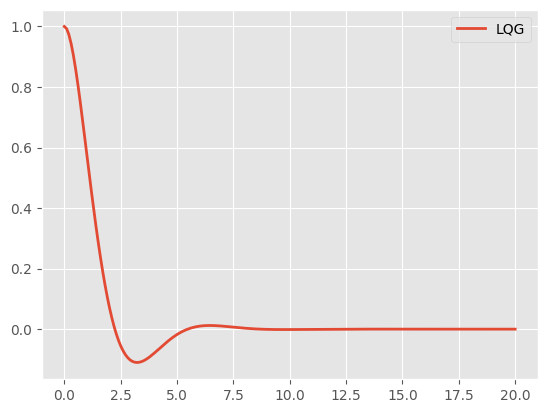

In [97]:
t_lqg, y_lqg = control.initial_response(sys_lqg, tsim, x0)
plt.plot(t_lqg,y_lqg,lw=2,label="LQG")
plt.legend()
plt.show()

## H2syn

In [98]:
Ap = A
Bp = np.hstack((np.sqrt(Qe),np.zeros((2,1)),-B))

Cp = np.vstack((np.sqrt(Q), np.zeros((1, 2)), C))

D11 = np.zeros((3,3))
D12 = np.vstack((np.zeros((2,1)),np.sqrt(R)))

D21 = np.hstack((np.zeros((1,2)),np.sqrt(Re)))
D22 = np.array([[0.]])

D1 = np.hstack((D11,D12))
D2 = np.hstack((D21,D22))

Dp = np.vstack((D1,D2))

In [99]:
P = control.ss(Ap,Bp,Cp,Dp)
P

<LinearIOSystem:sys[96]:['u[0]', 'u[1]', 'u[2]', 'u[3]']->['y[0]', 'y[1]', 'y[2]', 'y[3]']>

In [100]:
ncont = 1
nmeas = 1
K_h2 = control.h2syn(P,nmeas,ncont)
display(K_h2)
display(K_lqg)

StateSpace(array([[-1.17716062,  1.        ],
       [-1.60706712, -1.36690421]]), array([[1.17716062],
       [0.19285356]]), array([[0.41421356, 1.16690421]]), array([[0.]]))

<LinearIOSystem:sys[89]:['u[0]', 'u[1]']->['y[0]']>

In [102]:
sys_h2 = control.feedback(G,K,sign=-1)
sys_h2

<LinearICSystem:sys[98]:['u[0]']->['y[0]']>

In [103]:
x0 = np.array([[1, 0, 1, 0]]).T

In [104]:
t_h2, y_h2 = control.initial_response(sys_h2, tsim, x0)

## LQG vs H2syn

In [110]:
display(K_lqg)
display(K_h2)


<LinearIOSystem:sys[89]:['u[0]', 'u[1]']->['y[0]']>

StateSpace(array([[-1.17716062,  1.        ],
       [-1.60706712, -1.36690421]]), array([[1.17716062],
       [0.19285356]]), array([[0.41421356, 1.16690421]]), array([[0.]]))

In [111]:
display(sys_lqg)
display(sys_h2)

display(sys_lqg.A - sys_h2.A)

StateSpace(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [-1.        , -0.2       , -0.41421356, -1.16690421],
       [ 1.17716062,  0.        , -1.17716062,  1.        ],
       [ 0.19285356,  0.        , -1.60706712, -1.36690421]]), array([[0.],
       [1.],
       [0.],
       [0.]]), array([[1., 0., 0., 0.]]), array([[0.]]))

<LinearICSystem:sys[98]:['u[0]']->['y[0]']>

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

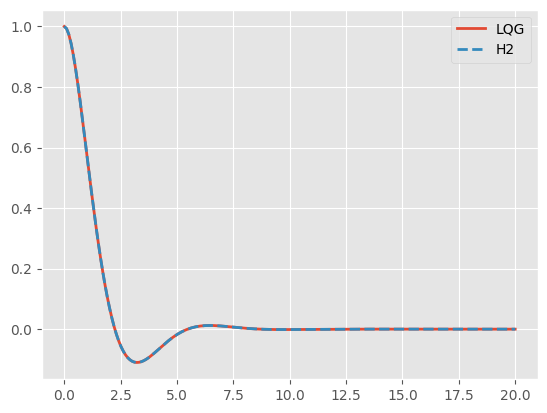

In [107]:
plt.plot(t_lqg,y_lqg,lw=2,label="LQG")
plt.plot(t_h2,y_h2,'--',lw=2,label="H2")
plt.legend()
plt.show()